In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from utils import LogScaler

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
# load data and check for missing values
df = pd.read_csv("housing.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 207 missing values in "total_bedrooms"

<AxesSubplot:>

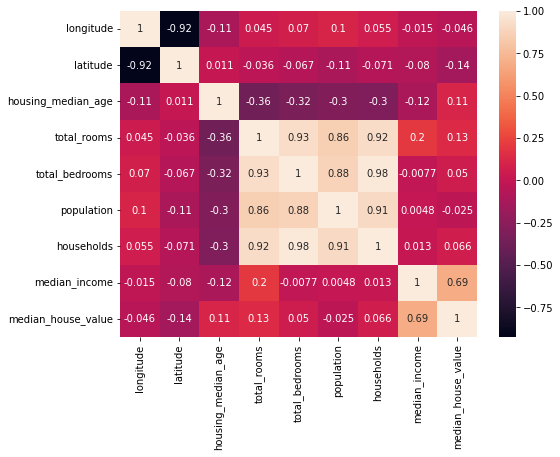

In [3]:
# visulize correlation
plt.figure(figsize=(8,6))
sb.heatmap(df.corr(),annot=True)

In [4]:
# check statistics
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
# check categorical columns for any imbalance
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# dropping "ISLAND" class
df.drop(df[df.ocean_proximity=="ISLAND"].index,inplace=True)
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
Name: ocean_proximity, dtype: int64

<AxesSubplot:xlabel='ocean_proximity', ylabel='total_bedrooms'>

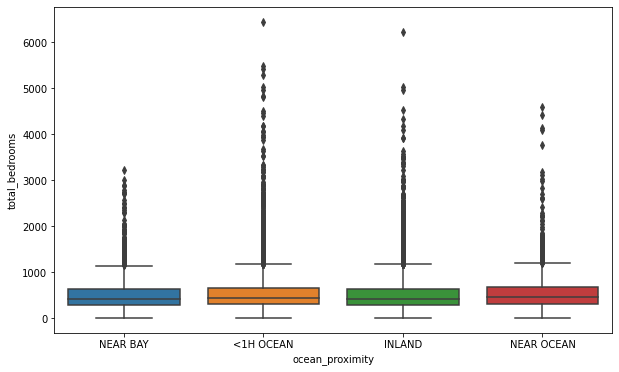

In [7]:
# visulaize relation between "total_bedrooms" and "ocean_proximity"
plt.figure(figsize=(10,6))
sb.boxplot(x=df.ocean_proximity,y=df.total_bedrooms)

In [8]:
# get mean value of each class in "ocean_proximity" for imputing missing values in "total_bedrooms"
for c in df.ocean_proximity.unique():
    print(c,df[df.ocean_proximity==c].total_bedrooms.mean())

NEAR BAY 514.1828193832599
<1H OCEAN 546.5391852999778
INLAND 533.8816194581281
NEAR OCEAN 538.6156773211568


In [9]:
def imputation(i):
    c = df.ocean_proximity.loc[i]
    if c == "NEAR BAY":
        return 514
    elif c == "<1H OCEAN":
        return 546
    elif c == "INLAND":
        return 533
    elif c == "NEAR OCEAN":
        return 538
    else:
        return 420
        

In [10]:
#impute missing values

df.fillna(0.0,inplace=True)

for i in df[df.total_bedrooms==0.0].index:
    df.total_bedrooms.loc[i] = imputation(i)

C:\Users\BJS\AppData\Local\Temp\ipykernel_1220\3431746620.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.total_bedrooms.loc[i] = imputation(i)


In [11]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

No more missing values

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

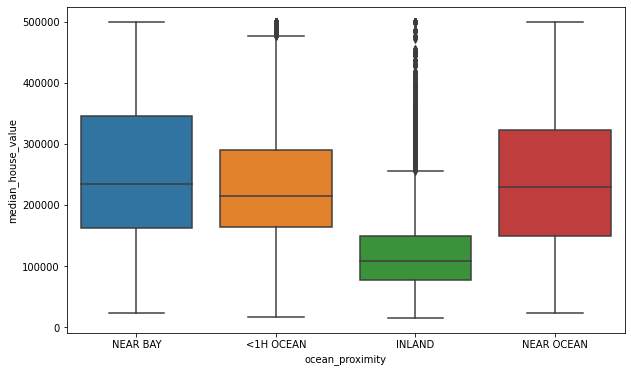

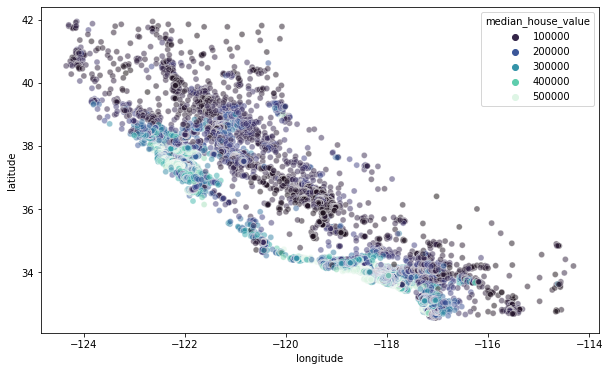

In [13]:
# visualize relation between "ocean_proximity" and target feature "median_house_value"
plt.figure(figsize=(10,6))
sb.boxplot(y=df.median_house_value,x=df.ocean_proximity)

plt.figure(figsize=(10,6))
sb.scatterplot(y=df.latitude,x=df.longitude,hue=df.median_house_value,
               palette="mako",alpha=0.5)

From the above plots, it is clear that houses closer to the coast are more expensive

In [14]:
# one hot encoding the classes
dummy = pd.get_dummies(df.ocean_proximity, drop_first=True)
df = pd.concat([df,dummy],axis=1).drop('ocean_proximity',axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20635 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20635 non-null  float64
 1   latitude            20635 non-null  float64
 2   housing_median_age  20635 non-null  float64
 3   total_rooms         20635 non-null  float64
 4   total_bedrooms      20635 non-null  float64
 5   population          20635 non-null  float64
 6   households          20635 non-null  float64
 7   median_income       20635 non-null  float64
 8   median_house_value  20635 non-null  float64
 9   INLAND              20635 non-null  uint8  
 10  NEAR BAY            20635 non-null  uint8  
 11  NEAR OCEAN          20635 non-null  uint8  
dtypes: float64(9), uint8(3)
memory usage: 2.1 MB


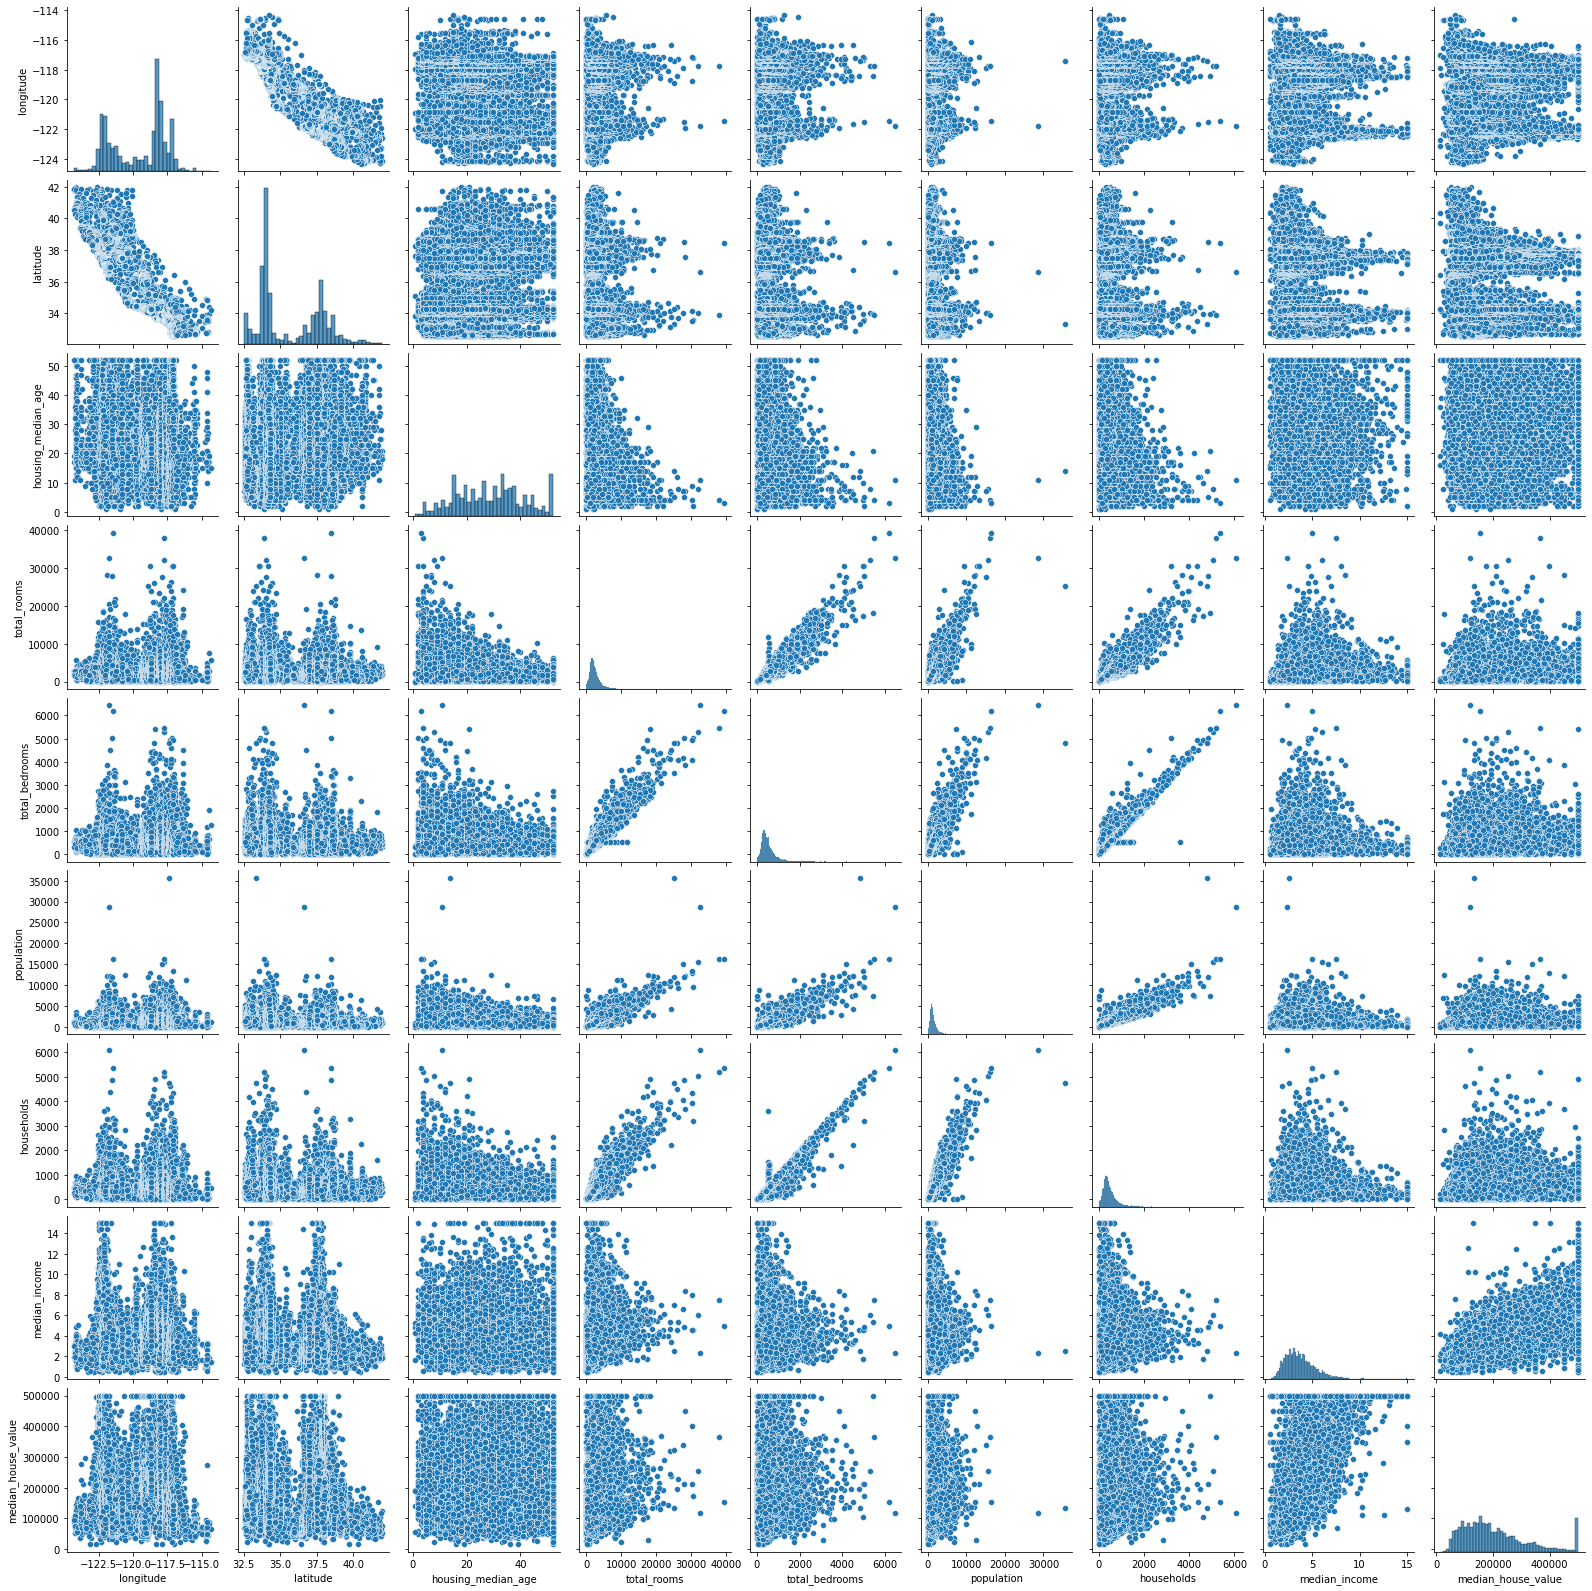

In [16]:
sb.pairplot(df.drop(['INLAND','NEAR BAY','NEAR OCEAN'],axis=1))

From the pairplot, its clear that the data is skewed and so a log scaling would be optimal

In [17]:
x = df.drop(["median_house_value"],axis=1).values
y = df.median_house_value.values

xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size=0.8,random_state=0)

scaler = LogScaler()
xtrain,ytrain = scaler.fit_transform(xtrain,ytrain)
xtest = scaler.transform(xtest)
    

linear regression
mae : 47074.56396664448


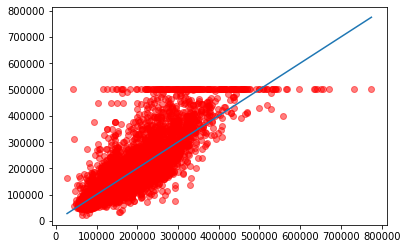


xgboost
mae : 30296.426464630786


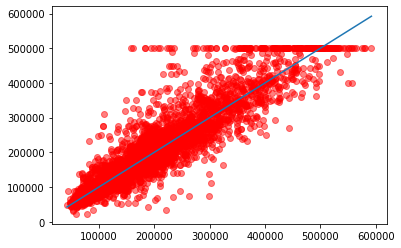


random forest
mae : 30612.41059038225


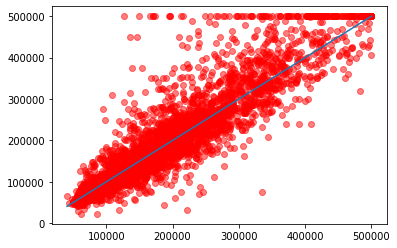

In [18]:
lin,xgb,rfr = LinearRegression(), XGBRegressor(), RandomForestRegressor()
regs = {"linear regression":lin,"xgboost":xgb,"random forest":rfr}

def plot_logs(ytest,ypred):
    logs = pd.DataFrame({'validation': ytest, 'predicted': ypred})
    plt.scatter(x=ytest,y=ypred,color='red',alpha=0.5)
    sb.lineplot(x=ytest,y=ytest,palette=['red'])
    plt.show()

for r in regs:
    regs[r].fit(xtrain,ytrain)
    pred = regs[r].predict(xtest)
    pred = np.exp(pred)
    print(r)
    print(f'mae : {mean_absolute_error(pred,ytest)}')
    plot_logs(pred,ytest)
    print()